In [1]:
import numpy as np
import pandas as pd
from scipy.stats import expon, gamma, powerlaw
import matplotlib.pyplot as plt

In [103]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters (inspired by Euro-Bund Futures, Page 13, Table 1)
TOTAL_TIME = 32400  # 9 AM - 6 PM in seconds (1 day)
NUM_LEVELS = 5  # 5 levels per side (bid/ask)
TICK_SIZE = 0.01  # Typical tick size for futures
INITIAL_MID_PRICE = 170.96  # Starting reference price
LAMBDA_GLOBAL = 20  # Baseline events/sec for homogeneous Poisson
LEVEL_WEIGHTS = [0.5, 0.2, 0.15, 0.1, 0.05]  # More events at best level
INTRA_DAY_BOOST = {0: 1.0, 10800: 1.0, 21600: 1.0, 32400: 2.0}  # Double rate 3 PM–6 PM (Page 16)

# Event type probabilities (constant for baseline, adjusted for seasonality)
EVENT_PROBS = {'L': 0.45, 'C': 0.45, 'M': 0.10}  # Reflecting high L/C, low M (Page 13)

# Initialize LOB with Gamma-distributed queue sizes (Page 17)
def initialize_lob():
    bid_queues = gamma.rvs(a=2, scale=10, size=NUM_LEVELS).tolist()  # Gamma for queue realism
    ask_queues = gamma.rvs(a=2, scale=10, size=NUM_LEVELS).tolist()
    bid_prices = [INITIAL_MID_PRICE - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
    ask_prices = [INITIAL_MID_PRICE + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
    return bid_queues, ask_queues, bid_prices, ask_prices

# Simulate LOB with stylized facts (homogeneous Poisson + enhancements)
def simulate_lob_stylized_facts():
    bid_queues, ask_queues, bid_prices, ask_prices = initialize_lob()
    mid_price = INITIAL_MID_PRICE
    events = []
    t = 0
    prev_events = []  # For mild clustering (simplified Hawkes)

    while t < TOTAL_TIME:
        # Intra-day seasonality (Page 16)
        lambda_scale = 1.0
        for time, boost in INTRA_DAY_BOOST.items():
            if t >= time:
                lambda_scale = boost

        # Choose level based on weights and side randomly
        level = np.random.choice(range(NUM_LEVELS), p=LEVEL_WEIGHTS)
        side = np.random.choice(['bid', 'ask'])
        queues = bid_queues if side == 'bid' else ask_queues
        prices = bid_prices if side == 'bid' else ask_prices
        q_before = queues[level]

        # Adjusted global intensity with seasonality
        lambda_global_adjusted = LAMBDA_GLOBAL * lambda_scale

        # Mild clustering (self-excitation, low impact, Page 30)
        excitation = 0
        for prev_t, prev_type in prev_events[-10:]:  # Limit history to 10 events
            dt = t - prev_t
            if dt > 0:
                excitation += 0.5 * np.exp(-0.05 * dt)  # Low alpha=0.5, beta=0.05
        lambda_global_final = max(0.1, lambda_global_adjusted + excitation)

        # Sample interarrival time (Poisson with adjusted lambda)
        dt = expon.rvs(scale=1/lambda_global_final)
        t += dt

        if t > TOTAL_TIME:
            break

        # Choose event type with constant probabilities (baseline)
        event_type = np.random.choice(['L', 'C', 'M'], p=[EVENT_PROBS['L'], EVENT_PROBS['C'], EVENT_PROBS['M']])

        # Sample order size (power-law for heavy tails, Page 21, 31)
        size = powerlaw.rvs(2.5, loc=1, scale=30, size=1)[0]  # Power-law with exponent -2.5, max 30 lots
        size = max(1, min(30, size))  # Ensure 1 ≤ size ≤ 30

        # Process event
        if event_type == 'L':
            queues[level] += size
        elif event_type == 'C' and q_before > 0:
            cancel_size = min(size, q_before)
            queues[level] -= cancel_size
        elif event_type == 'M':
            opp_queues = ask_queues if side == 'bid' else bid_queues
            if opp_queues[0] > 0:
                trade_size = min(size, opp_queues[0])
                opp_queues[0] -= trade_size
                # Price update with realistic volatility (Page 15)
                if opp_queues[0] == 0 and np.random.random() < 0.7:  # theta = 0.7 (Page 14)
                    mid_price += np.random.normal(0, 0.015)  # Small random walk for volatility
                    # Shift levels (simplified)
                    opp_queues.pop(0)
                    opp_queues.append(gamma.rvs(a=2, scale=10))
                    if side == 'bid':
                        ask_prices = [mid_price + i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]
                    else:
                        bid_prices = [mid_price - i * TICK_SIZE for i in range(1, NUM_LEVELS + 1)]

        # Record event
        events.append({
            'time': t,
            'type': event_type,
            'side': side,
            'level': level + 1,  # 1-based indexing like Table 1
            'size': size,
            'queue_before': q_before,
            'mid_price': mid_price
        })
        prev_events.append((t, event_type))
        if len(prev_events) > 100:  # Limit history for simplicity
            prev_events.pop(0)

    return pd.DataFrame(events), bid_queues, ask_queues, bid_prices, ask_prices

In [105]:
def compute_stats(df):
    """Calculate AES, AIT, event counts per level, single annualized volatility, and rolling volatility over time."""
    stats = {}
    for level in range(1, NUM_LEVELS + 1):
        level_df = df[df['level'] == level]
        stats[level] = {
            '#L': len(level_df[level_df['type'] == 'L']),
            '#C': len(level_df[level_df['type'] == 'C']),
            '#M': len(level_df[level_df['type'] == 'M']),
            'AES': level_df['size'].mean(),
            'AIT': np.diff(level_df['time']).mean() * 1000 if len(level_df) > 1 else np.nan  # ms
        }
    
    # Compute single annualized volatility for the entire LOB (Page 15, Table 2)
    unique_times = np.unique(df['time'])
    price_changes = np.diff(df['mid_price'].reindex(unique_times, method='ffill'))
    annualized_volatility = price_changes.std() * np.sqrt(252 * 32400)  # Annualized volatility
    
    # Convert stats to DataFrame and add single volatility as a separate row
    stats_df = pd.DataFrame(stats).T
    stats_df.loc['Volatility'] = np.nan  # Add row for single volatility (NaN for levels)
    stats_df.at['Volatility', 'Volatility'] = annualized_volatility  # Set single volatility value
    
    return stats_df

In [107]:
# Run simulation
stylized_data, stylized_bid_queues, stylized_ask_queues, stylized_bid_prices, stylized_ask_prices = simulate_lob_stylized_facts()

In [109]:
stylized_data.head()

,time,type,side,level,size,queue_before,mid_price
0,0.002389,M,ask,2,17.745305,11.310780,170.96
1,0.013526,C,ask,1,25.331649,28.667062,170.96
2,0.069156,C,bid,1,6.323578,6.191489,170.96
3,0.147850,L,ask,4,12.831219,19.989603,170.96
4,0.201346,C,bid,2,28.888162,14.944647,170.96


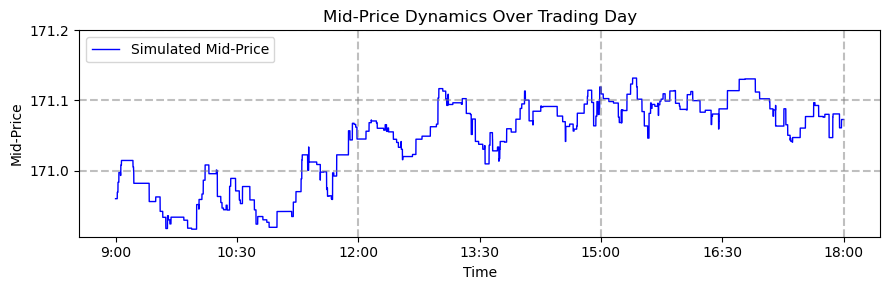

In [111]:
# Plot mid-price dynamics similar to Figure 9(a) (Page 15) with 1.5-hour interval ticks
times = stylized_data['time'].unique()
mid_prices = stylized_data['mid_price'].reindex(times, method='ffill')

# Convert time to hours (9 AM = 0 hours, 6 PM = 9 hours)
hours = (times / 3600)  # Convert seconds to hours (0 to 9)

# Create the plot
plt.figure(figsize=(9, 3))
plt.plot(hours, mid_prices, label='Simulated Mid-Price', color='blue', linewidth=1)
plt.xlabel('Time')
plt.ylabel('Mid-Price')
plt.title('Mid-Price Dynamics Over Trading Day')
plt.legend()
#plt.grid(True)

# Set x-axis ticks and labels for 1.5-hour intervals (9:00, 10:30, 12:00, 13:30, 15:00, 16:30, 18:00)
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']  # HH:MM format
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]  # Corresponding hours (0 = 9 AM, 9 = 6 PM)
plt.xticks(time_values, time_labels)
plt.yticks([171.0,171.1,171.2])
plt.axhline(y=171.0, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.1, color='gray', linestyle='--', alpha=0.5)
plt.axhline(y=171.2, color='gray', linestyle='--', alpha=0.5)

# Add vertical lines at key times (12:00, 15:00, 18:00)
plt.axvline(x=3, color='gray', linestyle='--', alpha=0.5)  # 12:00 (noon)
plt.axvline(x=6, color='gray', linestyle='--', alpha=0.5)  # 15:00 (3 PM)
plt.axvline(x=9, color='gray', linestyle='--', alpha=0.5)  # 18:00 (6 PM)

plt.tight_layout()

In [143]:
window_prices

0      170.960000
1      170.960000
2      170.960000
3      170.960000
4      170.960000
          ...    
595    171.014484
596    171.014484
597    171.014484
598    171.014484
599    171.014484
Name: mid_price, Length: 600, dtype: float64

In [165]:
#Compute rolling volatility over 10-minute windows (600 seconds, Page 15) with resampling
# Resample mid-price to 1-second intervals to reduce unique times
resampled_times = np.arange(0, TOTAL_TIME + 1, 1)  # 1-second intervals (32,401 points)
resampled_prices = stylized_data['mid_price'].reindex(resampled_times, method='ffill')

rolling_volatility = []
window_size = 600  # 10 minutes in seconds
times = resampled_times

for i in range(0, len(times) - window_size + 1): 
    window_times = times[i:i + window_size]
    window_prices = resampled_prices[window_times]
    window_changes = np.diff(window_prices)
    if len(window_changes) > 0:
        vol = window_changes.std() * np.sqrt(252 * 86400 / window_size) # Annualized per window
        rolling_volatility.append((times[i + window_size // 2], vol))  # Midpoint of window
rolling_vol = pd.DataFrame(rolling_volatility, columns=['time', 'volatility'])

In [166]:
stylized_stats = compute_stats(stylized_data)
print("Stylized Facts Simulated Data Stats (Level 1-5):")
print(stylized_stats)
print("\nRolling Volatility Over Time:")
print(rolling_vol)

Stylized Facts Simulated Data Stats (Level 1-5):
                  #L        #C       #M        AES         AIT  Volatility
1           178168.0  178279.0  39364.0  22.392433   81.857223         NaN
2            71510.0   71582.0  15735.0  22.374567  203.996687         NaN
3            53291.0   53595.0  11946.0  22.386561  272.652219         NaN
4            35487.0   35529.0   7959.0  22.385603  410.259040         NaN
5            17994.0   17793.0   4028.0  22.410597  813.745577         NaN
Volatility       NaN       NaN      NaN        NaN         NaN    0.761243

Rolling Volatility Over Time:
        time  volatility
0        300    0.214136
1        301    0.214136
2        302    0.214136
3        303    0.214136
4        304    0.214136
...      ...         ...
31797  32097    0.293200
31798  32098    0.293200
31799  32099    0.293200
31800  32100    0.293200
31801  32101    0.293200

[31802 rows x 2 columns]


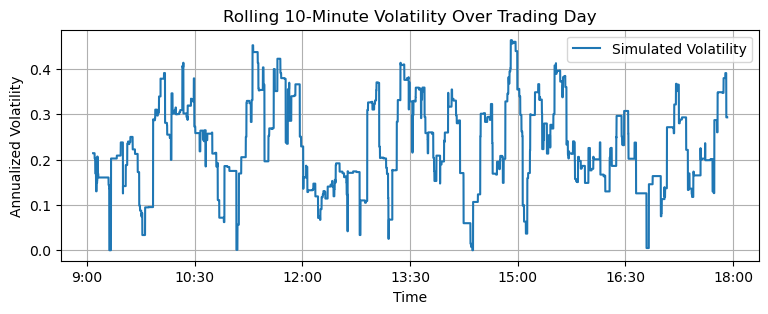

In [169]:
# Optional: Plot rolling volatility for Figure 9(b)-like visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
plt.plot(rolling_vol['time'] / 3600, rolling_vol['volatility'], label='Simulated Volatility')
plt.xlabel('Time')
time_labels = ['9:00', '10:30', '12:00', '13:30', '15:00', '16:30', '18:00']  # HH:MM format
time_values = [0, 1.5, 3, 4.5, 6, 7.5, 9]  # Corresponding hours (0 = 9 AM, 9 = 6 PM)
plt.xticks(time_values, time_labels)
plt.ylabel('Annualized Volatility')
plt.title('Rolling 10-Minute Volatility Over Trading Day')
plt.legend()
plt.grid(True)
#plt.savefig('figures/volatility_plot.pdf')
plt.show()

In [161]:
# Save to CSV for later use in report
stylized_data.to_csv('stylized_lob_data.csv', index=False)
rolling_vol.to_csv('rolling_volatility.csv', index=False)